Optimizer
==============
* 調整網路的權重，使得 loss 變小，常用的為梯度下降法
* 目的就是不斷的更新參數，去最小化損失函數的值，然後找到最佳解
* learning rate(學習率) η 相當的重要，太小會花費太多時間學習，太大有可能會造成overfitting，無法正確學習
* https://medium.com/@chih.sheng.huang821/%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92-%E5%9F%BA%E7%A4%8E%E6%95%B8%E5%AD%B8-%E4%B8%89-%E6%A2%AF%E5%BA%A6%E6%9C%80%E4%BD%B3%E8%A7%A3%E7%9B%B8%E9%97%9C%E7%AE%97%E6%B3%95-gradient-descent-optimization-algorithms-b61ed1478bd7

torch.optim.SGD(params, lr = 0.01, momentum=0.9)
----------------------
* 準確率梯度下降法 (stochastic gradient decent)
* w' = w -  η * ∂L/∂W，W 為權重(weight)參數，L 為損失函數(loss function)，∂L/∂W 是損失函數對參數的梯度(微分)
* Momentum: Vt = momentum * Vt-1 - η * ∂L/∂W, w' = w + Vt

torch.optim.RMSprop(params, lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
-----------------
* RMSProp算法的全称叫 Root Mean Square Prop
* Adagrad会累加之前所有的梯度平方，而RMSprop仅仅是计算对应的平均值，因此可缓解Adagrad算法学习率下降较快的问题
* Sdw = momentum * Sdw + (1 - momentum) * dw^2
* Sdb = momentum * Sdb + ((1 - momentum) * db^2
* Sdw和Sdb分别是损失函数在前一轮迭代过程中累积的梯度梯度动量
* w' = w - alpha * dw / (√Sdw + ϵ)
* b' = b - alpha * db / (√Sdb + ϵ)

torch.optim.Adagrad(params, lr=0.01, lr_decay=0, weight_decay=0)
-------------------------
* AdaGrad就是會依照梯度去調整 learning rate η 的優化器
* w' = w - η * 1/√(n+ϵ) * ∂L/∂W，n為已計算所有梯度值的平方和
* ϵ 為平滑值，加上 ϵ 的原因是為了不讓分母為0，ϵ 一般值為1e-8
* lr_decay ( float,可選) –學習率衰減（默認: 0）
* weight_decay ( float,可選) –權重衰減（L2懲罰）（默認: 0）
* 前期梯度較小的時候，n較小，能夠放大學習率
* 後期梯度較大的時候，n較大，能夠約束學習率，但分母上梯度平方的累加會越來越大，會使梯度趨近於0，訓練便會結束

torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
--------------------------
* Momentum 跟 AdaGrad 的結合
* Adam為目前較常使用的Optimizer
* mt = beta1 * mt-1 + (1 - beta2) * ∂Lt/∂Wt
* vt = beta1 * Vt-1 + (1 - beta2) * (∂Lt/∂Wt)^2
* mt' = mt / (1 - beta1^t)
* vt' = vt / (1 - beta2^t)
* w' = w - η * (mt' / (√vt' + ϵ))，mt' 與 vt' 為偏離校正

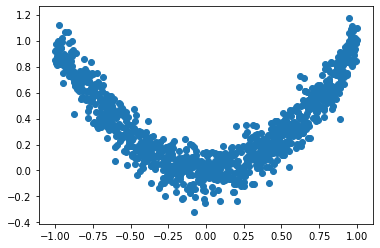

In [2]:
import torch
import torch.utils.data as Data
import torch.nn.functional as F
import matplotlib.pyplot as plt

torch.manual_seed(1)    # reproducible

LR = 0.01
BATCH_SIZE = 32
EPOCH = 12

# fake dataset
x = torch.unsqueeze(torch.linspace(-1, 1, 1000), dim=1)
y = x.pow(2) + 0.1 * torch.normal(torch.zeros(*x.size())) # y = x^2 + b

# plot dataset
plt.scatter(x.numpy(), y.numpy())
plt.show()

# 使用上节内容提到的 data loader
torch_dataset = Data.TensorDataset(x, y)
loader = Data.DataLoader(dataset=torch_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2,)

In [3]:
# 默认的 network 形式
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(1, 20)   # hidden layer
        self.predict = torch.nn.Linear(20, 1)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

# 为每个优化器创建一个 net
net_SGD         = Net()
net_Momentum    = Net()
net_RMSprop     = Net()
net_Adam        = Net()
nets = [net_SGD, net_Momentum, net_RMSprop, net_Adam]

In [4]:
# different optimizers
opt_SGD         = torch.optim.SGD(net_SGD.parameters(), lr=LR)
opt_Momentum    = torch.optim.SGD(net_Momentum.parameters(), lr=LR, momentum=0.8)
opt_RMSprop     = torch.optim.RMSprop(net_RMSprop.parameters(), lr=LR, alpha=0.9)
opt_Adam        = torch.optim.Adam(net_Adam.parameters(), lr=LR, betas=(0.9, 0.99))
optimizers = [opt_SGD, opt_Momentum, opt_RMSprop, opt_Adam]

loss_func = torch.nn.MSELoss() # 平方差總和平均
losses_his = [[], [], [], []]   # 记录 training 时不同神经网络的 loss

In [5]:
for epoch in range(EPOCH):
    print('Epoch: ', epoch)
    for step, (b_x, b_y) in enumerate(loader):

        # 对每个优化器, 优化属于他的神经网络
        for net, opt, l_his in zip(nets, optimizers, losses_his):
            output = net(b_x)              # get output for every net
            loss = loss_func(output, b_y)  # compute loss for every net
            opt.zero_grad()                # clear gradients for next train
            loss.backward()                # backpropagation, compute gradients
            opt.step()                     # apply gradients
            l_his.append(loss.data.numpy())     # loss recoder

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11


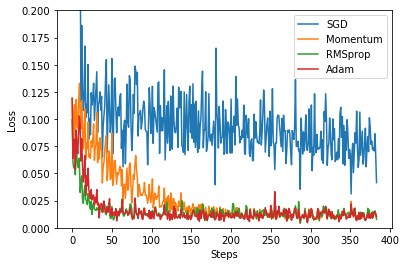

In [6]:
labels = ['SGD', 'Momentum', 'RMSprop', 'Adam']
for i, l_his in enumerate(losses_his):
    plt.plot(l_his, label=labels[i])
plt.legend(loc='best')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.ylim((0, 0.2))
plt.show()